In [504]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

# Przykładowy zestaw danych

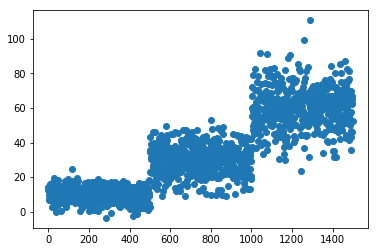

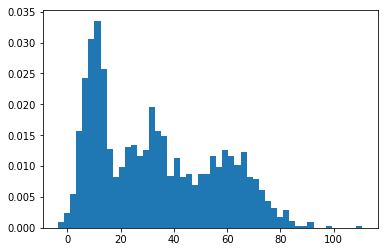

In [505]:
data = np.concatenate((4*np.random.randn(500, 1) + 10, 8*np.random.randn(500, 1) + 30, 12*np.random.randn(500, 1) + 60))

plt.figure()
plt.plot(data, 'o')
plt.show()

plt.figure()
plt.hist(data, bins=50, normed=True)
plt.show()

# Wykres rozkładu GMM

In [506]:
def PlotGMM(data, p, m, s):
    plt.figure()
    plt.hist(data, bins=50, normed=True)
    sample_x = np.linspace(data.min() - 0.1 * (data.max() - data.min()), data.max() + 0.1 * (data.max() - data.min()), 100)[np.newaxis].T
    sample_y = (norm.pdf(sample_x, loc = m, scale = np.sqrt(s)) * p).sum(axis=1)
    plt.plot(sample_x, sample_y, 'r-')
    plt.show()

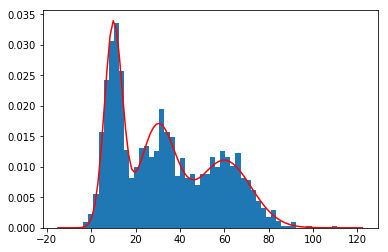

In [507]:
PlotGMM(data, np.array([0.3333, 0.3333, 0.3333]), np.array([10.0, 30.0, 60.0]), np.array([16.0, 64.0, 144.0]))

# Algorytm EM

Rozpatrujemy przypadek jednowymiarowy ($d = 1$). Zestaw danych uczących składa się z $N$ jednowymiarowych wektorów danych $x_1, x_2, \ldots, x_N \in \mathbb{R}$.

Rozpatrujemy mieszaninę $K$ jednowymiarowych niezależnych rozkładów gaussowskich. Prawdopodobieństwa wyboru kolejnych składników mieszaniny to $p_1, p_2, \ldots, p_K \in \mathbb{R}$. Wartości oczekiwane i odchylenia standardowe kolejnych składników mieszaniny to, odpowiednio, $m_1, m_2, \ldots, m_K \in \mathbb{R}$ i $s_1, s_2, \ldots, s_K \in \mathbb{R}$. Niech $\mathbf{p} = (p_1, p_2, \ldots, p_K) \in \mathbb{R}^K$, $\mathbf{m} = (m_1, m_2, \ldots, m_K) \in \mathbb{R}^K$, $\mathbf{s} = (s_1, s_2, \ldots, s_K) \in \mathbb{R}^K$.

Niech $R$ oznacza ukrytą zmienną losową określającą składnik mieszaniny użyty w losowanu wektora danych. Losując wektory danych, losowano też wartości zmiennej losowej $R$, lecz nie zostały one zapisane w zestawie danych uczących i nie są one znane (jest to ukryta zmienna losowa). Oznaczmy je przez $r_1, r_2, \ldots, r_N \in \mathbb{R}$. Dla wygody dalszych obliczeń wprowadźmy współczynniki $r_{ik} \in \mathbb{R}$, dla $i = 1, 2, \ldots, N$ i $k = 1, 2, \ldots, K$, takie że $r_{ik} = 1$ jeśli $r_i = k$ oraz $r_{ik} = 0$ w przeciwnym przypadku. 

Funkcja wiarygodności ma postać:
$$L(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = P(x_1, x_2, \ldots, x_N | \mathbf{p}, \mathbf{m}, \mathbf{s}) = \prod_{i=1}^N P(x_i | \mathbf{p}, \mathbf{m}, \mathbf{s}) = \prod_{i=1}^N \sum_{k=1}^K r_{ik} p_k P(x_i | m_k, s_k) = \prod_{i=1}^N \sum_{k=1}^K r_{ik} p_k f(x_i; m_k, s_k),$$
gdzie
$$f(x; \mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}} \exp(-\frac{(x-\mu)^2}{2\sigma^2}).$$

Możemy zlogartymować funkcję wiarygodności, a ponieważ dla każdego $i$, tylko jeden składnik wewnętrznej sumy jest niezerowy (bo punkt danych $x_i$ pochodzi z dokładnie jednego składnika mieszaniny, tzn. współczynnik $r_{ik}$ jest niezerowy dla dokładniej jednego $k$), to z logarytmem można wejść pod wewnętrzną sumę:
$$l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \log L(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N \sum_{k=1}^K r_{ik} \log[p_k f(x_i; m_k, s_k)],$$
skąd
$$l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N \sum_{k=1}^K r_{ik} [\log(p_k) - \log(s_k) - \log(\sqrt{2 \pi}) - \frac{(x_i-m_k)^2}{2s_k^2}].$$



## Krok E:

Krok E polega na estymacji wartości ukrytej zmiennej losowej $R$ (przy ustalonych wartościach parametrów $\mathbf{p}$, $\mathbf{m}$, $\mathbf{s}$).

$$r_{ik} = P(R = k | x_i) = \frac{p_k f(x_i; m_k, s_k)}{\sum_{j=0}^K p_j f(x_i; m_j, s_j)}$$



## Krok M:

Krok M polega na wyznaczeniu wartości parametrów $\mathbf{p}$, $\mathbf{m}$, $\mathbf{s}$ maksymalizujących funkcję wiarygodności (przy ustalonych wartościach ukrytej zmiennej losowej $R$).

W celu wyznaczenia wartości parametru $\mathbf{p}$ stosujemy metodę mnożników Lagrange'a dla funkcji wiarygodności i warunku $\sum_{k=1}^K p_k = 1$:
$$\frac{\partial}{\partial p_l} l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N r_{il} \frac{1}{p_l} = p_l^{-1} \sum_{i=1}^N r_{il}$$
$$\frac{\partial}{\partial p_l} \sum_{k=1}^K p_k = 1,$$
skąd
$$p_l = \lambda \sum_{i=1}^N r_{il},$$
dla pewnego współczynnika Lagrange'a $\lambda \in \mathbb{R}$, a ponieważ
$$1 = \sum_{k=1}^K p_k = \sum_{k=1}^K \lambda \sum_{i=1}^N r_{ik} = \lambda \sum_{k=1}^K \sum_{i=1}^N r_{ik} = \lambda \sum_{i=1}^N \sum_{k=1}^K r_{ik} = \lambda \sum_{i=1}^N 1 = \lambda N,$$
to $\lambda = \frac{1}{N}$, zatem
$$p_l = \frac{1}{N} \sum_{i=1}^N r_{il}.$$

W celu wyznaczenia wartości parametru $\mathbf{m}$ przyrównujemy do zera pochodną
$$\frac{\partial}{\partial m_l} l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N r_{il} \frac{(x_i-m_l)}{s_l^2} = s_l^{-2} [\sum_{i=1}^N r_{il} x_i - m_l \sum_{i=1}^N r_{il}],$$
skąd
$$m_l = \frac{\sum_{i=1}^N r_{il} x_i}{\sum_{i=1}^N r_{il}} = \frac{\sum_{i=1}^N r_{il} x_i}{N p_l}.$$

Podobnie, w celu wyznaczenia wartości parametru $\mathbf{s}$ przyrównujemy do zera pochodną
$$\frac{\partial}{\partial s_l} l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N  r_{il} [-\frac{1}{s_l} + \frac{(x_i-m_l)^2}{s_l^3}] = s_l^{-1} [s_l^{-2} \sum_{i=1}^N r_{il} (x_i-m_l)^2 - \sum_{i=1}^N r_{il}],$$
skąd
$$s_l^2 = \frac{\sum_{i=1}^N r_{il} (x_i-m_l)^2}{\sum_{i=1}^N r_{il}} = \frac{\sum_{i=1}^N r_{il} (x_i-m_l)^2}{N p_l}.$$

In [508]:
def EM(data, K, T):
    N = data.shape[0]

    p = np.random.rand(K)
    p = p / np.sum(p)

    m = np.linspace(data.min(), data.max(), K+2)[1:-1]
    s = np.ones(K)

    loglikelihood = np.zeros(T)
    loglikelihood_optimal = - np.inf
    p_optimal = p
    m_optimal = m
    s_optimal = s
    for t in range(T):
        R = p * norm.pdf(data, loc = m, scale = np.sqrt(s)) #dla każdej pary m,s dla każdego x \in data
        R = R / R.sum(axis = 1)[np.newaxis].T
        p = R.sum(axis = 0) / N
        m = (R * data).sum(axis = 0) / (N * p)
        s = (R * (data - m)**2).sum(axis = 0) / (N * p)
    
        loglikelihood[t] = (R * np.log(p * norm.pdf(data, loc = m, scale = np.sqrt(s)))).sum()

        if (loglikelihood_optimal < loglikelihood[t]):
            loglikelihood_optimal = loglikelihood[t]
            p_optimal = p
            m_optimal = m
            s_optimal = s

    return p_optimal, m_optimal, s_optimal, loglikelihood

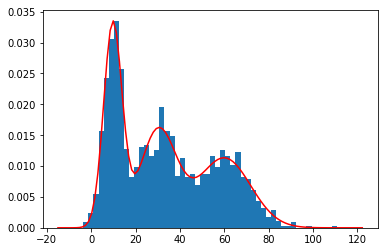

[ 0.34068333  0.32192796  0.33738871]
[  9.73647028  30.17744751  59.9393228 ]
[  17.14228436   66.52967778  141.31087538]


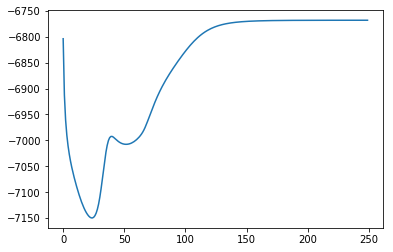

In [509]:
p, m, s, ll = EM(data, 3, 250)

PlotGMM(data, p, m, s)

print(p)
print(m)
print(s)

plt.figure()
plt.plot(ll)
plt.show()

# Wersja dla d = 2

In [510]:
data2 = np.concatenate((np.random.multivariate_normal([10,10],np.diag([20,20]),500), 
                        np.random.multivariate_normal([0,0],np.diag([7,10]),500), 
                        np.random.multivariate_normal([-4,-2],np.diag([1,7]),500)))


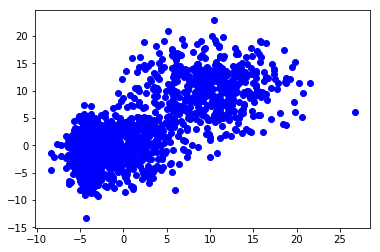

In [511]:
plt.figure()
plt.plot(data2[:,0], data2[:,1], 'bo')
plt.show()

In [512]:
def EM2(data, K, T):
    N = data.shape[0]

    p = np.random.rand(K)
    p = p / np.sum(p)

    #m = np.linspace(data.min(), data.max(), 2*K+4)[2:-2].reshape((K,2))
    m = np.linspace(0.1, 0.1 * K, 2*K).reshape((K,2))
    
    S = np.ones((K,2))

    loglikelihood = np.zeros(T)
    loglikelihood_optimal = - np.inf
    
    p_optimal = p
    m_optimal = m
    S_optimal = S
    
    for t in range(T):
            R = p * norm.pdf(data[:,0][np.newaxis].T, loc = m[:,0], scale = np.sqrt(S[:,0])) * norm.pdf(data[:,1][np.newaxis].T, loc = m[:,1], scale = np.sqrt(S[:,1]))
                #zmienne niezależne więc gęstość 2d to iloczyn dwóch 1d
            R = R / R.sum(axis = 1)[np.newaxis].T
            
            p = R.sum(axis = 0) / N
            
            m[:,0] = (R * data[:,0][np.newaxis].T).sum(axis = 0) / (N * p)
            m[:,1] = (R * data[:,1][np.newaxis].T).sum(axis = 0) / (N * p)
            
            S[:,0] = (R * (data[:,0][np.newaxis].T - m[:,0])**2).sum(axis = 0) / (N * p)
            S[:,1] = (R * (data[:,1][np.newaxis].T - m[:,1])**2).sum(axis = 0) / (N * p)
    
            loglikelihood[t] = (R * np.log(p * norm.pdf(data[:,0][np.newaxis].T, loc = m[:,0], scale = np.sqrt(S[:,0])) * norm.pdf(data[:,1][np.newaxis].T, loc = m[:,1], scale = np.sqrt(S[:,1])))).sum()

            if (loglikelihood_optimal < loglikelihood[t]):
                loglikelihood_optimal = loglikelihood[t]
                p_optimal = p
                m_optimal = m
                s_optimal = S

    return p_optimal, m_optimal, S_optimal, loglikelihood

def square_diff(x,y):
    return x*x + y*y - 2.*x*y


[ 0.44958928  0.22719068  0.32322005]
[[ -3.9849466   -2.05169092]
 [ -0.15383603   0.03534564]
 [  9.85594272  10.24240479]]
[[  0.82242128   8.38591157]
 [  9.17013648   9.87046546]
 [ 18.90483241  17.99567546]]


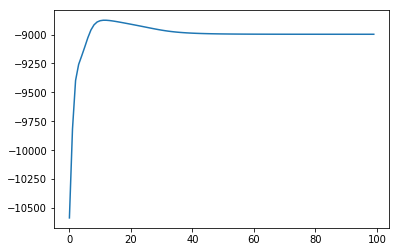

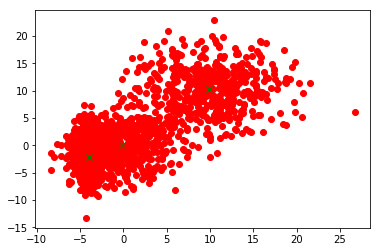

In [513]:
"""from mpl_toolkits import mplot3d
z = multivariate_normal.pdf(data2, mean = [0,0], cov = [[1,0],[0,1]])
plt.figure()
plt.plot(data2[:,0],data2[:,1], z)
plt.show()
ax = plt.axes(projection='3d')
ax.scatter3D(data2[:,0], data2[:,1], z, c=z);"""
p, m, s, ll = EM2(data2, 3, 100)

print(p)
print(m)
print(s)

plt.figure()
plt.plot(ll)
plt.show()

plt.figure()
plt.plot(data2[:,0],data2[:,1],'ro',m[:,0],m[:,1],'gx')
plt.show()